In [1]:
args_str = '--model=rnn_separate --num_epochs=100 --num_data_workers=8 --num_backpropagation_time_steps=10 --learning_rate=0.000031 --neuron_num_layers=3 --neuron_residual --save_all_predictions --experiment_selection_path= --parameter_reduction --loss=poisson'



In [2]:
import sys
import scipy
sys.path.append('/storage/praha1/home/houston/mcs-source')

from execute_model import init_parser, init_model_path
from nn_model.model_executer import ModelExecuter
from nn_model.globals import POS_ORI_DICT, LAYER_TO_PARENT, EXCITATORY_LAYERS
from nn_model.connection_learning import ConnectionAffine, get_features, pairwise_delta
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import matplotlib.colors as colors
from dataclasses import dataclass, field
import seaborn as sns
import pickle
import matplotlib.colors as mcolors

In [3]:
sns.set_theme(
    style="ticks",
    context="paper",
)

In [4]:
# parser = init_parser()
#
# args = parser.parse_args(args_str.replace('"', '').split())
# args.model_filename = init_model_path(args)
#
# executer = ModelExecuter(args)
#
# executer._load_best_model()

In [5]:
@dataclass
class NeuralConnectionPopulation:
    layer_name_pre: str
    layer_name_post: str
    lateral: np.ndarray
    autapses: np.ndarray | None
    features: dict[str, tuple[torch.Tensor, torch.Tensor]]


    
    def get_title(self):
        def layer_to_polarity(layer):
            if layer in EXCITATORY_LAYERS:
                return 'Exc'
            return 'Inh'
        title = LAYER_TO_PARENT[self.layer_name_pre]
        p1 = layer_to_polarity(self.layer_name_pre)
        p2 = layer_to_polarity(self.layer_name_post)
        return f"{title} {p1}->{p2}"


In [6]:
def diag_mask(x):
    return torch.eye(x.size(0), dtype=torch.bool, device=x.device)

In [7]:
# def get_affine_modules():
#     for idx, (layer_name, layer) in enumerate(executer.model.layers.items()):
#         yield layer.rnn_cell.weights_hh
#         yield layer.rnn_cell.weights_lateral


In [8]:
# @torch.no_grad()
# def affine_module_to_population(x: ConnectionAffine) -> NeuralConnectionPopulation:
#     lateral = x.weight()
#     autapses = None
#     features = get_features(x.layer_name_pre, x.layer_name_post)
#
#     if x.weight.has_self_connection:
#         assert lateral.shape[0] == lateral.shape[1]
#         autapses = lateral.diagonal()
#         mask = ~diag_mask(lateral).flatten()
#
#
#     lateral = lateral.cpu().detach().numpy()
#     return NeuralConnectionPopulation(
#         x.layer_name_pre,
#         x.layer_name_post,
#         lateral,
#         autapses,
#         features
#     )

In [9]:
# all_populations = list(map(affine_module_to_population, get_affine_modules()))

In [10]:
# translate = {
#     'V1_Exc_L4':   'L4(E)',
#     'V1_Inh_L4':   'L4(I)',
#     'V1_Exc_L23': 'L2/3(E)',
#     'V1_Inh_L23': 'L2/3(I)',
# }

In [11]:
with open('connections_sparse.pickle', 'rb') as f:
    real_conn = pickle.load(f)

In [12]:
with open('../testing_dataset/pos_ori_phase_dictionary.pickle', 'rb') as f:
    feature_dict = pickle.load(f)

total_dict = {}
for feat in feature_dict.values():
    for name in feat:
        if name not in total_dict:
            total_dict[name] = feat[name]
        else:
            total_dict[name] = np.concat((total_dict[name], feat[name]))



In [13]:
all_populations = []

for (pre, post), lateral in real_conn.items():
    if not LAYER_TO_PARENT[pre] == LAYER_TO_PARENT[post]:
        continue
    f1 = feature_dict[pre]
    f2 = feature_dict[post]
    features = {
        k: (torch.tensor(f1[k]), torch.tensor(f2[k])) for k in f1.keys()
    }
    population = NeuralConnectionPopulation(pre, post, lateral, None, features)
    all_populations.append(population)


In [14]:
ticks = ["π/4", "π/2", "3/4π", "π", ]

In [15]:
l4 = [x for x in all_populations if "L4" in x.layer_name_pre.upper()]
l23 = [x for x in all_populations if "L2" in x.layer_name_pre.upper()]

In [26]:
def plot(populations, feature_to_plot:str='ori', max_dist=None):
    assert feature_to_plot in ('ori', 'phase')
    is_ori = feature_to_plot == 'ori'
    plt.figure(figsize=(15, 10))
    for i, population in enumerate(populations):
        print(i)
        is_exc = population.layer_name_pre in EXCITATORY_LAYERS
        features = population.features
        x = features['x']
        y = features['y']
        ori = features['ori']
        feat = features[feature_to_plot]
        dx = pairwise_delta(*x)
        dy = pairwise_delta(*y)
        # relative distance
        dist = (dx ** 2 + dy ** 2) ** 0.5
        dist = dist.cpu().detach().numpy()
        # relative orientation
        ori = pairwise_delta(*ori).cpu().detach().numpy()
        pred = population.lateral.toarray().flatten()
        

        
        if is_ori:
            x_feat = ori
        else:
            x_feat = pairwise_delta(*features['phase']).cpu().detach().numpy()

        if isinstance(population.lateral, np.ndarray):
            pred = population.lateral.flatten()
            valid_mask = np.ones_like(pred, dtype=bool)
        else:
            pred = population.lateral.toarray().flatten()
            valid_mask = pred != 0

        if max_dist is not None:
            valid_mask &= dist < max_dist

        dist = dist[valid_mask]
        x_feat = x_feat[valid_mask]
        pred = pred[valid_mask]

        if not is_exc:
            pred = -pred
        
        binned = scipy.stats.binned_statistic_2d(x_feat, dist, pred, statistic='mean', bins=(151, 100))
        
        left = binned.x_edge.min()
        right = binned.x_edge.max()
        bottom = binned.y_edge.min()
        top = binned.y_edge.max()
        extent = [left, right, bottom, top]
    
    
        # sample_idx = np.random.choice(len(x), 100000)
        plt.subplot(220 + i + 1)
        xlines = np.arange(-4, 5) / 4 * np.pi
        if not is_ori:
            xlines *= 2
        for xline in xlines:
            plt.axvline(xline, color="black", linestyle=":",)

        if is_ori:
            plt.xticks(xlines, labels=["-π", "-3/4π", "-π/2", "-π/4", "0", "π/4", "π/2", "3/4π", "π"])
        else:
            plt.xticks(xlines, labels=["-2π", "-3/2π", "-π", "-π/2", "0", "π/2", "π", "3/2π", "2π"])
        cmap = 'jet'
        if 'inh' in population.layer_name_pre.lower():
            cmap += '_r'


        # w_min, w_max = np.min(pred), np.max(pred)

        # if is_exc:
        #     norm = mcolors.Normalize(vmin=0.0, vmax=w_max)
        # else:
        #     norm = mcolors.Normalize(vmin=w_min, vmax=0.0)
            
        plt.imshow(binned.statistic.T, origin='lower', aspect='auto', interpolation="none", extent=extent, cmap=cmap)
    
    
        if is_ori:
            plt.xlabel('Orientation difference')
        else:
            plt.xlabel('Phase difference')
        plt.ylabel('Distance (cm)')
        if is_ori:
            plt.xlim(-np.pi, np.pi)
        else:
            plt.xlim(-2*np.pi, 2*np.pi)
        plt.ylim(0, dist.max())
        cbar = plt.colorbar()
        cbar.set_label('Connection Weight\n(white = no data)')
        title = population.get_title()
        plt.title(title)
    plt.tight_layout()
    plt.savefig(f"connections_{title}_{feature_to_plot}.pdf", bbox_inches='tight')
    plt.show()


0
1
2
3


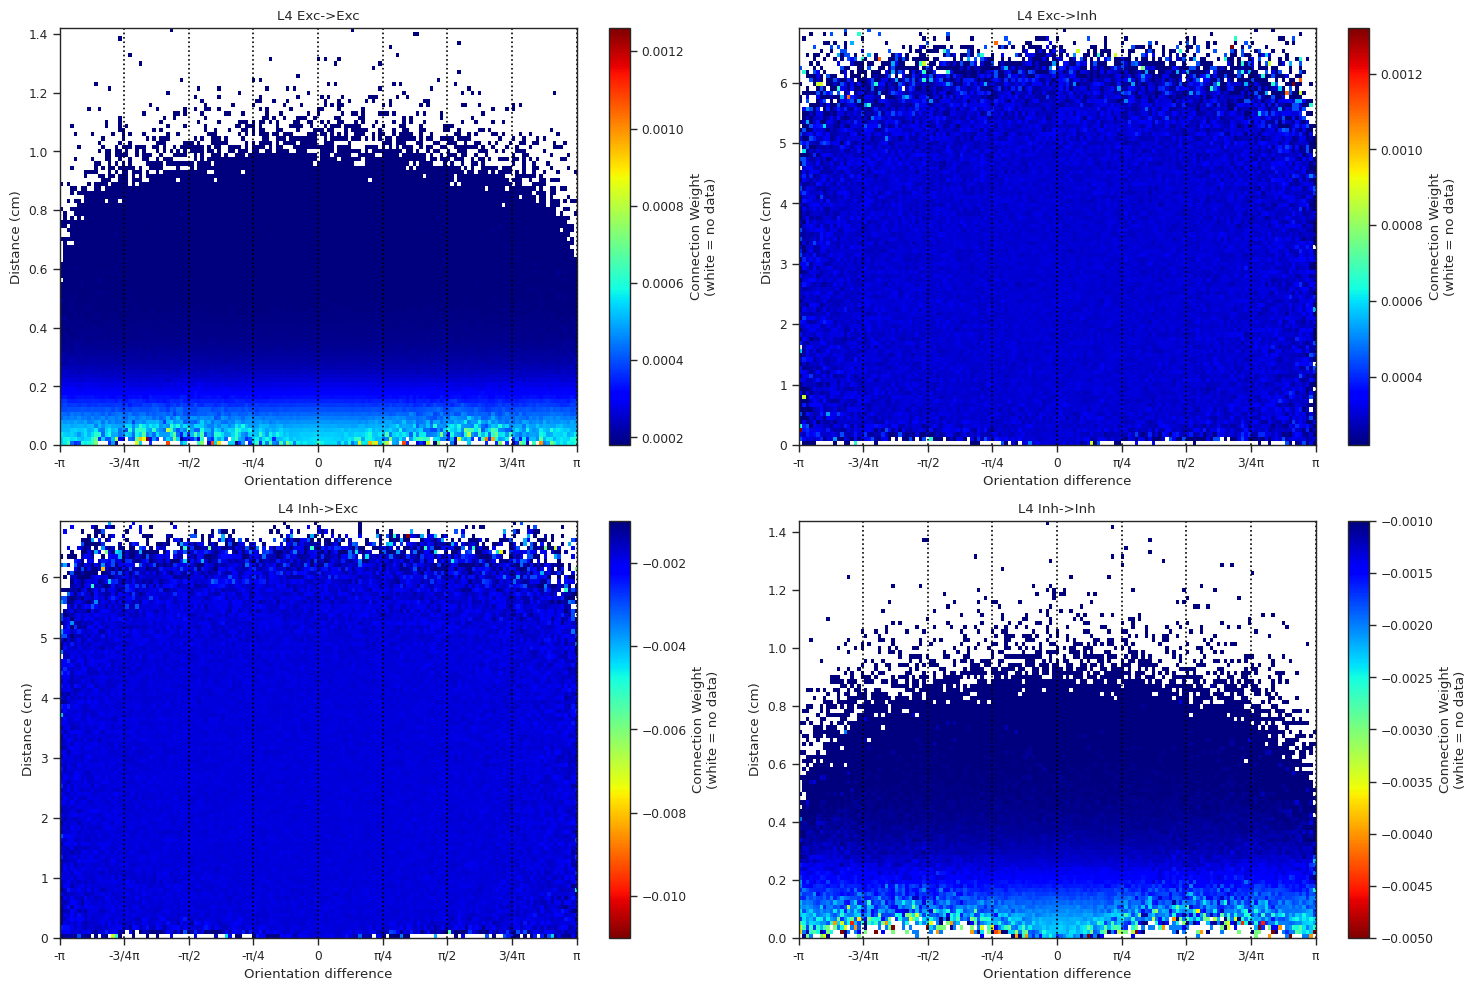

In [27]:
plot(l4)

0
1
2
3


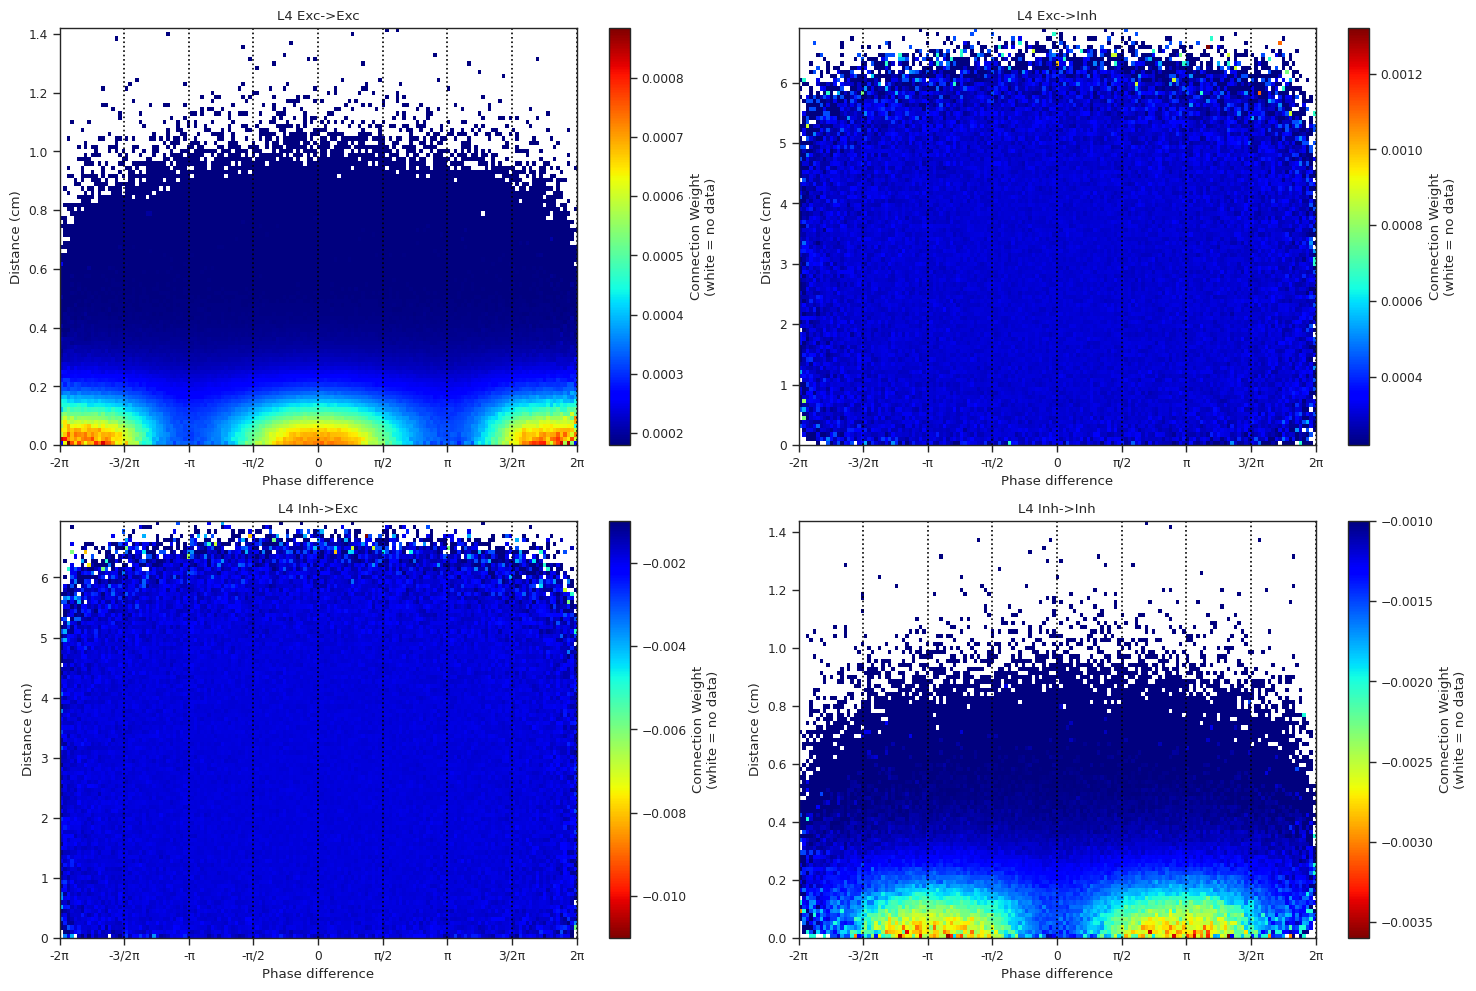

In [28]:
plot(l4, 'phase')

0
1
2
3


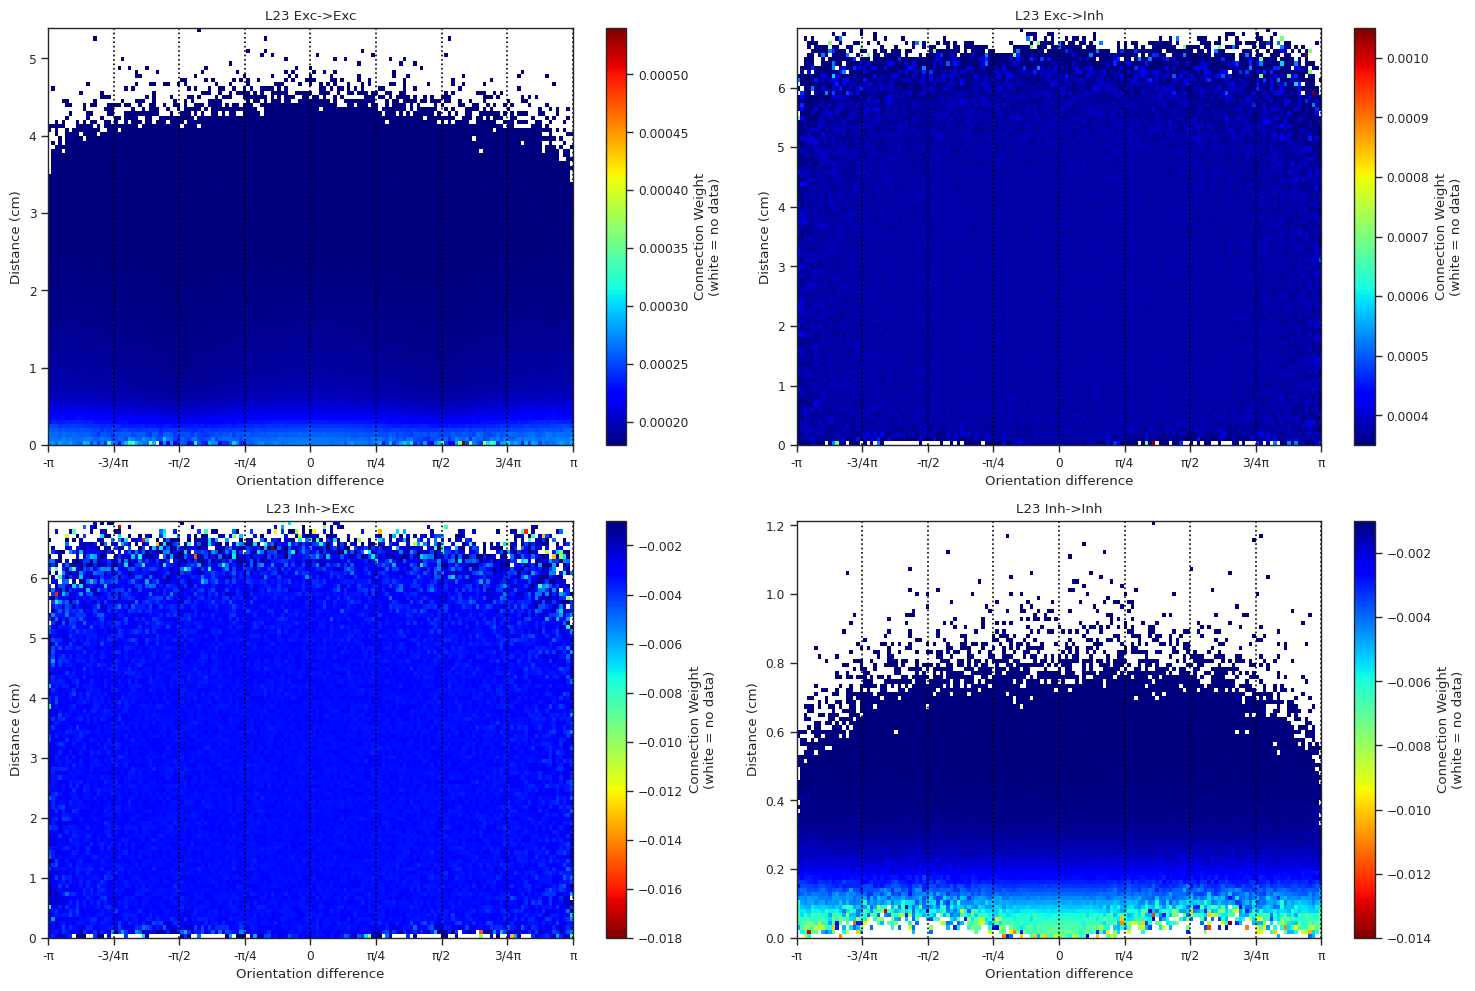

In [29]:
plot(l23)

In [ ]:
for population in all_populations:
    if population.autapses is None:
        continue
    x = population.autapses.cpu().detach()
    ax = sns.histplot(x, bins=50, element='step')
    ax.set_title(population.layer_name_pre)
    vline = x
    # ax.axvline(vline, c='r', label=f'Avg: {x.numpy():.2f}')
    print('median', np.median(x))
    plt.show()
    

In [32]:
f = total_dict
binned = scipy.stats.binned_statistic_2d(
    f['x'], f['y'], f['ori'], statistic='mean', bins=(200, 200)
)
extent = [
    binned.x_edge.min(), binned.x_edge.max(),
    binned.y_edge.min(), binned.y_edge.max()
]

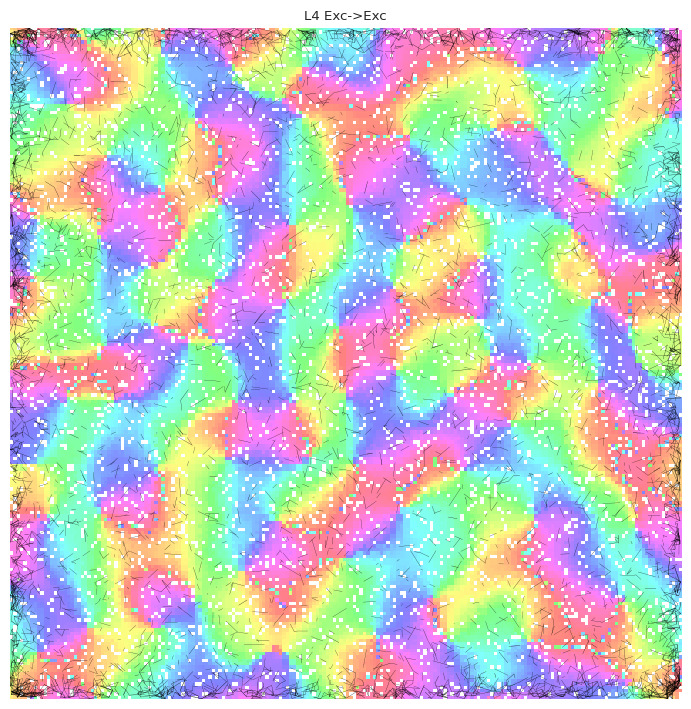

IndexError: index 36726 is out of bounds for axis 0 with size 9375

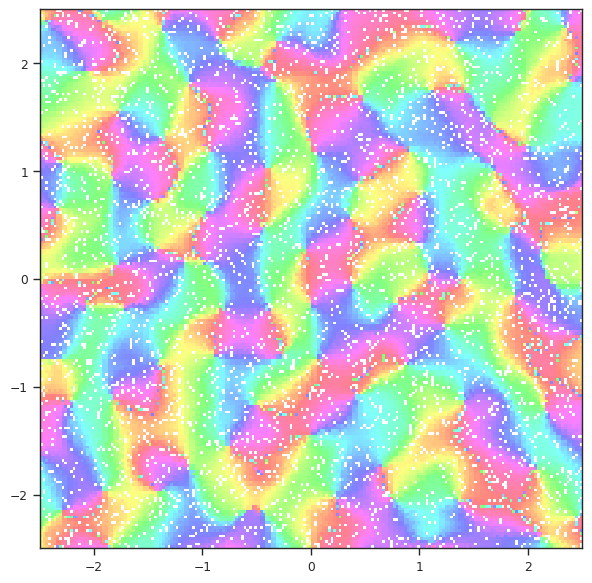

In [34]:
for pop in all_populations:
    plt.figure(figsize=(7, 7))

    W = torch.tensor(pop.lateral.toarray()).detach().cpu()
    if pop.layer_name_pre == pop.layer_name_post:
        W.fill_diagonal_(0)
    w_max = W.abs().max().item()

    
    # pick top-k
    absW = W.abs().flatten()
    k = min(6000, absW.numel())
    top_vals, top_idx = torch.topk(absW, k)
    post_idxs, pre_idxs = np.unravel_index(top_idx.numpy(), W.shape)

    f_pre = feature_dict[pop.layer_name_pre]
    f_post = feature_dict[pop.layer_name_post]

    plt.imshow(
        binned.statistic.T,
        origin='lower',
        aspect='auto',
        interpolation='none',
        extent=extent,
        cmap='hsv',
        alpha=0.5,
    )

    for idx in range(k):
        j = post_idxs[idx]
        i = pre_idxs[idx]
        w = W[j, i].item()
        x1, y1 = f_pre['x'][i], f_pre['y'][i]
        x2, y2 = f_post['x'][j], f_post['y'][j]
        lw = abs(w) / (3 * w_max)
        plt.plot([x1, x2], [y1, y2], c='black', linewidth=lw)

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.axis('off')
    plt.tight_layout()
    plt.title(pop.get_title())
    plt.show()
